# Getting started

This notebook shows how to get started with Quantus, using a very simple example. For this purpose, we use a LeNet model and MNIST dataset.

- Make sure to have GPUs enabled to speed up computation.
- Skip running the first cell if you do not use Google Colab.

In [1]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages.
!pip install captum opencv-python
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
# Imports general.
import sys
import gc
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2

# Import package.
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/quantus')
import quantus

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

Normalising attributions (or taking their absolute values) may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome. 
Normalisation is set to True and absolute value is set to True
Normalising attributions (or taking their absolute values) may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome. 
Normalisation is set to True and absolute value is set to True


## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [3]:
# Load datasets and make loaders.
test_samples = 24
transformer = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.MNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

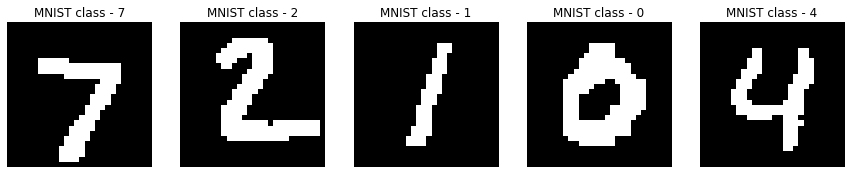

In [4]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.reshape(x_batch[i].cpu().numpy(), (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"MNIST class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

### 1.2 Train a LeNet model

(or any other model of choice). 
Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch.

In [5]:
class LeNet(torch.nn.Module):
    """Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch."""
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: LeNet(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (relu_3): ReLU()
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (relu_4): ReLU()
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)



In [6]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if evaluate:
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [7]:
path_model_weights = "drive/MyDrive/Projects/quantus/tutorials/assets/mnist"

if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
    
else:

    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        train_data=train_loader,
                        test_data=test_loader,
                        device=device,
                        epochs=20,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                        evaluate=True)

    # Save model.
    torch.save(model.state_dict(), path_model_weights)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Model test accuracy: 99.01%


### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [8]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
a_batch_intgrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_saliency, a_batch_intgrad]]

Visulize attributions given model and input-output *pairs*.

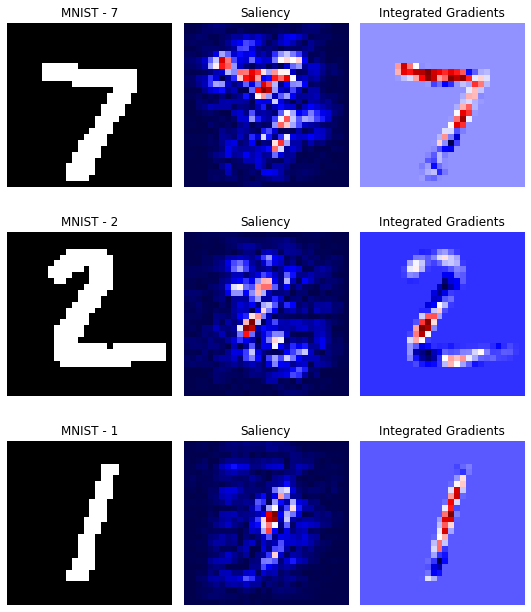

In [17]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow((np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"MNIST - {y_batch[i].item()}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a_batch_saliency[i], cmap="seismic")
    axes[i, 1].title.set_text(f"Saliency")
    axes[i, 1].axis("off")
    a = axes[i, 2].imshow(a_batch_intgrad[i], cmap="seismic")
    axes[i, 2].title.set_text(f"Integrated Gradients")
    axes[i, 2].axis("off")
plt.savefig(f'{path}/quantus/tutorials/assets/mnist_example.png', dpi = 400)
plt.tight_layout()
plt.show()

## 2. Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [10]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
scores_saliency = quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_saliency,
   **{"explain_func": quantus.explain, "method": "Saliency", "device": device, "img_size": 28, "normalise": False, "abs": False})

In [15]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
scores_intgrad = quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device, "img_size": 28, "normalise": False, "abs": False})

In [16]:
print(f"max-Sensitivity scores by Yeh et al., 2019\n" \
      f"\n • Saliency = {np.mean(scores_saliency):.2f} ({np.std(scores_saliency):.2f})." \
      f"\n • Integrated Gradients = {np.mean(scores_intgrad):.2f} ({np.std(scores_intgrad):.2f})."
      )

max-Sensitivity scores by Yeh et al., 2019

 • Saliency = 0.41 (0.15).
 • Integrated Gradients = 0.17 (0.05).


In [13]:
metrics = {"max-Sensitivity": quantus.MaxSensitivity(**{"nr_samples": 10,
                                                        "perturb_radius": 0.1,
                                                        "norm_numerator": quantus.fro_norm,
                                                        "norm_denominator": quantus.fro_norm,
                                                        "perturb_func": quantus.uniform_sampling,
                                                        "similarity_func": quantus.difference})}

xai_methods = {"Saliency": a_batch_saliency,
               "IntegratedGradients": a_batch_intgrad}

results = quantus.evaluate(evaluation_metrics=metrics,
                           explanation_methods=xai_methods,
                           model=model,
                           x_batch=x_batch,
                           y_batch=y_batch,
                           agg_func=np.mean,
                           **{"explain_func": quantus.explain, "device": device, "img_size": 28, "normalise": False, "abs": False})

df = pd.DataFrame(results)
df